In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('vmCloud_data.csv')

# Specify the names of the two schemas you want to keep
schema1 = 'timestamp'
schema2 = 'memory_usage'

# Create a list of columns to drop (all columns except schema1 and schema2)
columns_to_drop = [col for col in df.columns if col not in [schema1, schema2]]

# Drop the unwanted columns
df = df.drop(columns=columns_to_drop)
df = df.dropna(subset=['memory_usage', 'timestamp'])

# Convert 'time_stamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'])


# Sort DataFrame by 'time_stamp' column
df = df.sort_values(by='timestamp')
df = df.head(1500000)

# Group the data by hour and calculate the mean CPU usage for each hour
df = df.groupby(pd.Grouper(key='timestamp', freq='H')).mean()
df

,memory_usage
timestamp,
2023-01-01 00:00:00,49.923959
2023-01-01 01:00:00,52.341910
2023-01-01 02:00:00,47.118333
2023-01-01 03:00:00,50.955101
2023-01-01 04:00:00,48.357204
...,...
2023-07-05 14:00:00,51.635650
2023-07-05 15:00:00,48.597321
2023-07-05 16:00:00,49.796013


In [7]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['memory_usage'])

# Extract and print test results
print('Dickey-Fuller Test Results:')
print(f'Test Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

Dickey-Fuller Test Results:
Test Statistic: -36.85682792109155
p-value: 0.0
Critical Values:
	1%: -3.4318183732172622
	5%: -2.8621888447477692
	10%: -2.567115383838868


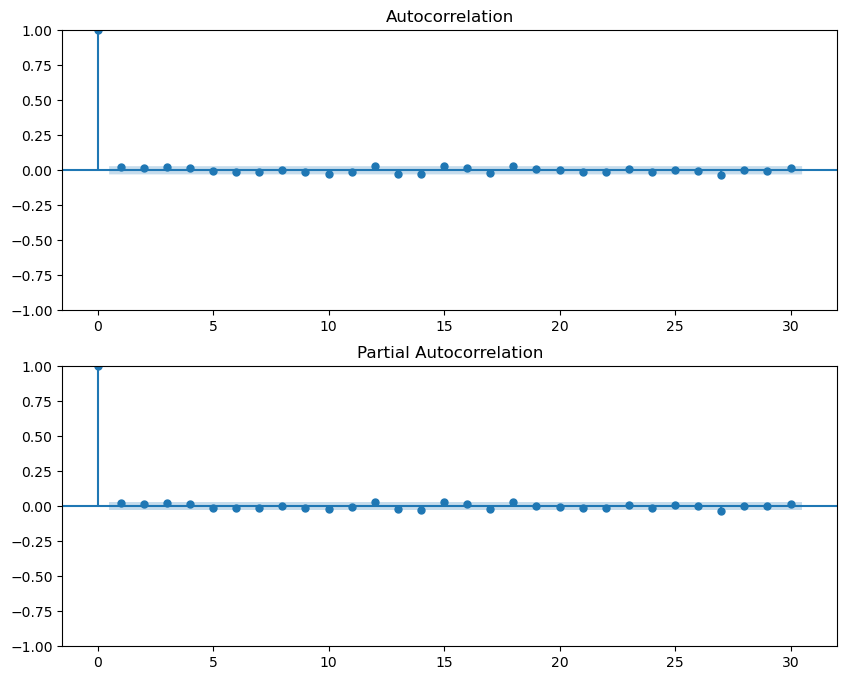

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(10, 8))
plot_acf(df['memory_usage'], ax=ax[0], lags=30)
plot_pacf(df['memory_usage'], ax=ax[1], lags=30)
plt.show()

                               SARIMAX Results                                
Dep. Variable:           memory_usage   No. Observations:                 4459
Model:                ARIMA(50, 0, 0)   Log Likelihood               -8318.557
Date:                Sun, 05 May 2024   AIC                          16741.114
Time:                        14:18:11   BIC                          17074.053
Sample:                    01-01-2023   HQIC                         16858.483
                         - 07-05-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.9809      0.026   1954.677      0.000      49.931      50.031
ar.L1          0.0223      0.015      1.466      0.143      -0.007       0.052
ar.L2          0.0174      0.015      1.154      0.2

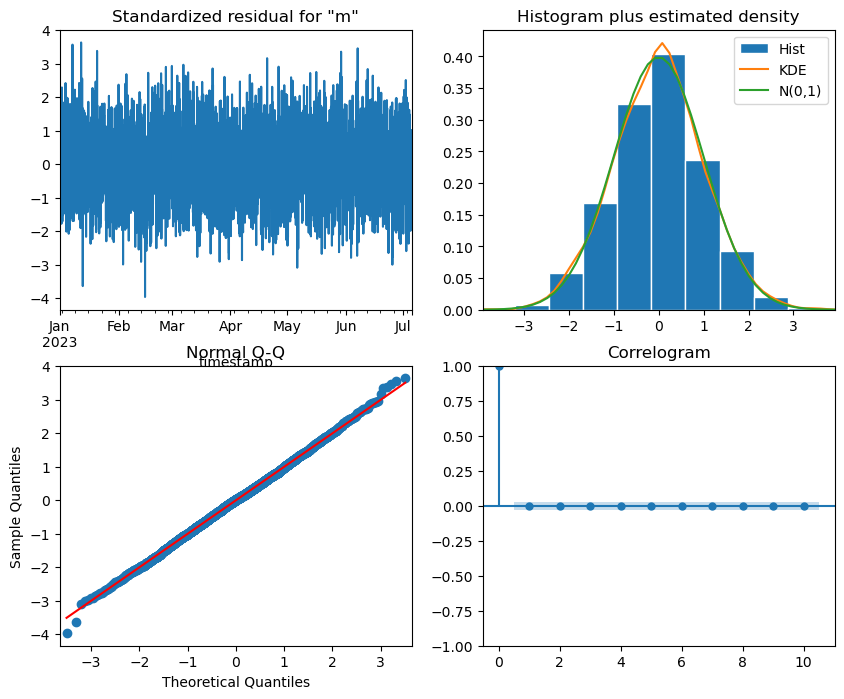

Forecasted values for the next 10 steps:
2023-07-05 19:00:00    50.222047
2023-07-05 20:00:00    50.213593
2023-07-05 21:00:00    49.979448
2023-07-05 22:00:00    50.202318
2023-07-05 23:00:00    49.905706
2023-07-06 00:00:00    49.977816
2023-07-06 01:00:00    50.047378
2023-07-06 02:00:00    49.907834
2023-07-06 03:00:00    49.867115
2023-07-06 04:00:00    49.836130
Freq: H, Name: predicted_mean, dtype: float64


In [9]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA


# Fit ARIMA model
model1 = ARIMA(df['memory_usage'], order=(50, 0, 0))  # Example: ARIMA(1, 0, 1)
result = model1.fit()

# Print model summary
print(result.summary())

# Plot residuals
result.plot_diagnostics(figsize=(10, 8))
plt.show()

# Forecast next 10 steps
forecast = result.forecast(steps=10)
print("Forecasted values for the next 10 steps:")
print(forecast)


Mean Absolute Error (MAE): 1.2407750096294676
Mean Squared Error (MSE): 2.501553265017683
Root Mean Squared Error (RMSE): 1.581629939340326


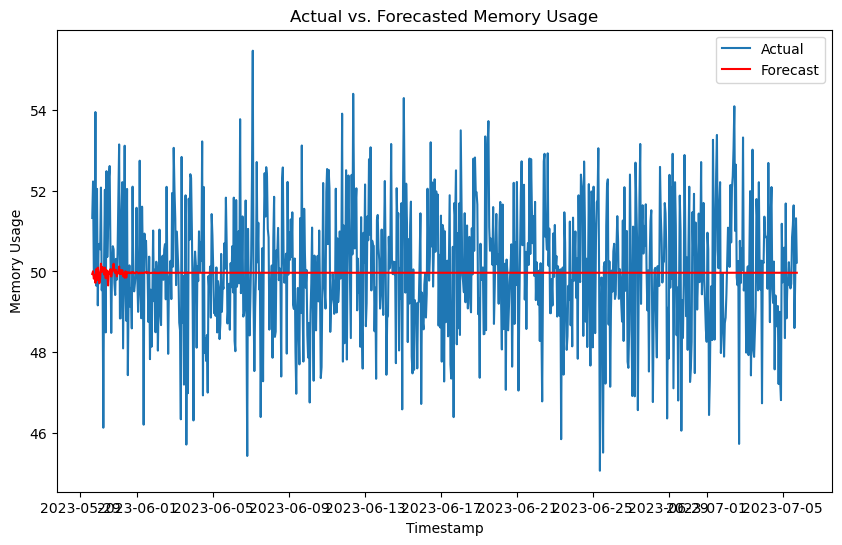

In [10]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


# Split the data into training and test sets (e.g., 80% for training, 20% for testing)
train_size = int(len(df) * 0.8)
train_data, test_data = df['memory_usage'][:train_size], df['memory_usage'][train_size:]

# Fit ARIMA model
model1 = ARIMA(train_data, order=(50, 0, 0))  # Example: ARIMA(1, 0, 1)
result = model1.fit()

# Forecast on test data
forecast = result.forecast(steps=len(test_data))

# Calculate accuracy metrics
mae = mean_absolute_error(test_data, forecast)
mse = mean_squared_error(test_data, forecast)
rmse = mean_squared_error(test_data, forecast, squared=False)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Visualize actual vs. forecasted values
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.xlabel('Timestamp')
plt.ylabel('Memory Usage')
plt.title('Actual vs. Forecasted Memory Usage')
plt.legend()
plt.show()


Forecasted values for the next 16 steps:
2023-05-29 15:00:00    49.936110
2023-05-29 16:00:00    50.002773
2023-05-29 17:00:00    49.819383
2023-05-29 18:00:00    49.899706
2023-05-29 19:00:00    49.716194
2023-05-29 20:00:00    50.053062
2023-05-29 21:00:00    49.783588
2023-05-29 22:00:00    50.092400
2023-05-29 23:00:00    49.947181
2023-05-30 00:00:00    49.706432
2023-05-30 01:00:00    49.828902
2023-05-30 02:00:00    50.191199
2023-05-30 03:00:00    49.988656
2023-05-30 04:00:00    50.107106
2023-05-30 05:00:00    50.031643
2023-05-30 06:00:00    49.925691
Freq: H, Name: predicted_mean, dtype: float64


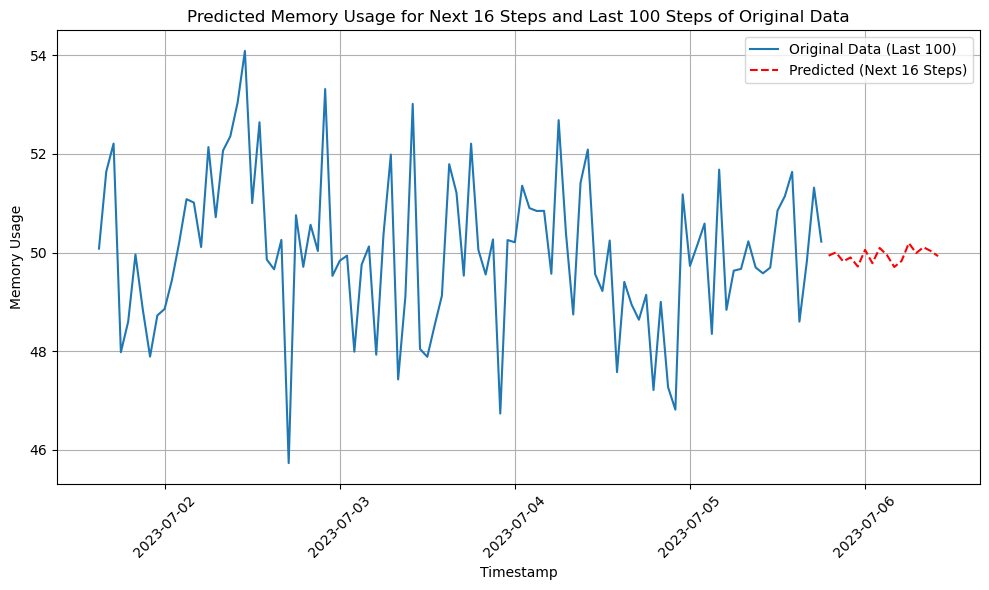

In [12]:
# Forecast next 16 steps
forecast_next_16 = result.forecast(steps=16)
print("Forecasted values for the next 16 steps:")
print(forecast_next_16)

# Plot predicted values for the next 16 steps and last 100 steps of original data
plt.figure(figsize=(10, 6))
plt.plot(df.index[-100:], df['memory_usage'][-100:], label='Original Data (Last 100)')
plt.plot(pd.date_range(start=df.index[-1], periods=17, freq='H')[1:], forecast_next_16, label='Predicted (Next 16 Steps)', color='red', linestyle='--')
plt.xlabel('Timestamp')
plt.ylabel('Memory Usage')
plt.title('Predicted Memory Usage for Next 16 Steps and Last 100 Steps of Original Data')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Normalize the data
scaler = MinMaxScaler()
df['memory_usage_normalized'] = scaler.fit_transform(df[['memory_usage']])

# Prepare data for LSTM
sequence_length = 10  # Number of time steps to look back
data = []
target = []
for i in range(len(df) - sequence_length):
    data.append(df['memory_usage_normalized'].iloc[i:i+sequence_length].values)
    target.append(df['memory_usage_normalized'].iloc[i+sequence_length])

data = np.array(data)
target = np.array(target)

# Define the LSTM model
model2 = Sequential()
model2.add(LSTM(50, input_shape=(sequence_length, 1)))
model2.add(Dense(1))

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model2.summary()


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


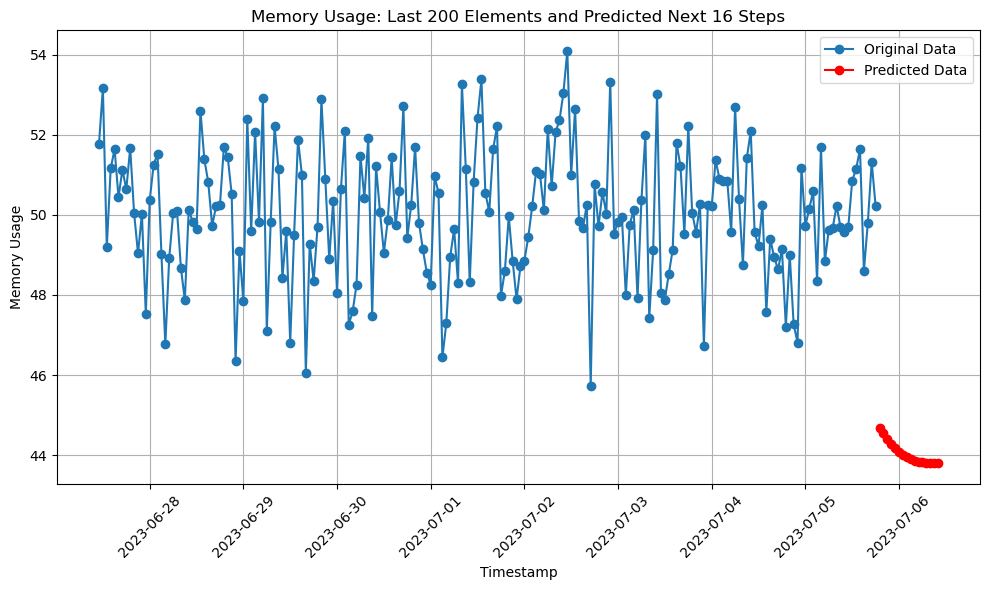

In [15]:
# Select the last 200 rows of the DataFrame
last_200_elements = df.tail(200)

# Prepare the last 10 data points for prediction
input_data = last_200_elements['memory_usage_normalized'].values[-sequence_length:].reshape((1, sequence_length, 1))

# Predict the next 16 steps
predicted_values = []
for _ in range(16):
    prediction = model2.predict(input_data)
    predicted_values.append(prediction[0][0])
    input_data = np.append(input_data[:, 1:, :], prediction[0].reshape((1, 1, 1)), axis=1)

# Denormalize the predicted values
predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(last_200_elements.index, last_200_elements['memory_usage'], marker='o', linestyle='-', label='Original Data')
plt.plot(last_200_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), predicted_values, marker='o', linestyle='-', color='red', label='Predicted Data')
plt.xlabel('Timestamp')
plt.ylabel('Memory Usage')
plt.title('Memory Usage: Last 200 Elements and Predicted Next 16 Steps')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


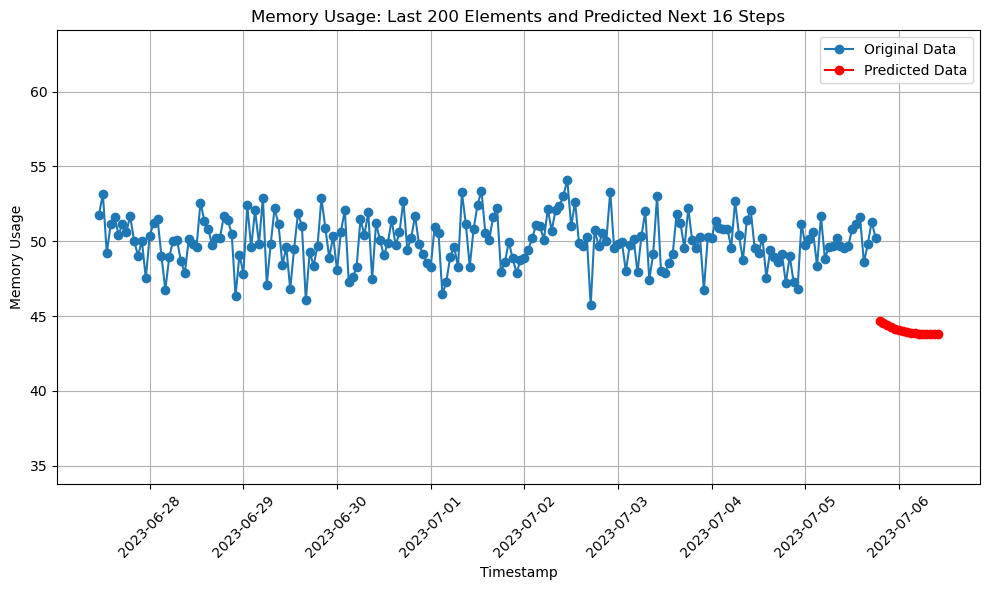

In [16]:
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(last_200_elements.index, last_200_elements['memory_usage'], marker='o', linestyle='-', label='Original Data')

# Plot predicted data
plt.plot(last_200_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), predicted_values, marker='o', linestyle='-', color='red', label='Predicted Data')

# Zoom in on predicted values
y_min = min(last_200_elements['memory_usage'].min(), np.min(predicted_values))
y_max = max(last_200_elements['memory_usage'].max(), np.max(predicted_values))
plt.ylim(y_min - 10, y_max + 10)

plt.xlabel('Timestamp')
plt.ylabel('Memory Usage')
plt.title('Memory Usage: Last 200 Elements and Predicted Next 16 Steps')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


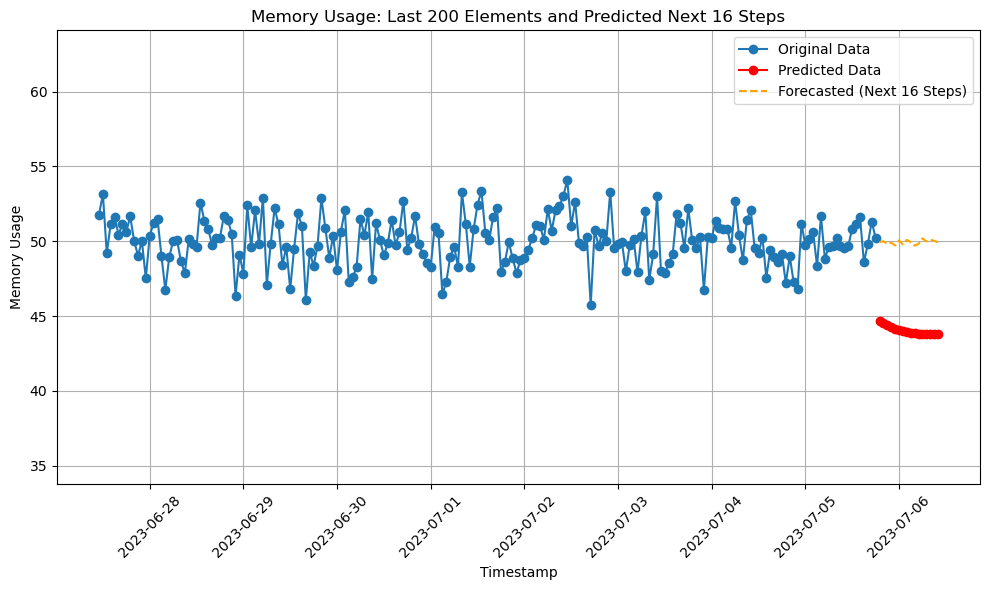

In [17]:
# Plot the graph
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(last_200_elements.index, last_200_elements['memory_usage'], marker='o', linestyle='-', label='Original Data')

# Plot predicted data
plt.plot(last_200_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), predicted_values, marker='o', linestyle='-', color='red', label='Predicted Data')

# Plot forecasted data for the next 16 steps (if available)
if 'forecast_next_16' in locals():
    plt.plot(pd.date_range(start=df.index[-1], periods=17, freq='H')[1:], forecast_next_16, label='Forecasted (Next 16 Steps)', color='orange', linestyle='--')

# Zoom in on predicted values
y_min = min(last_200_elements['memory_usage'].min(), np.min(predicted_values))
y_max = max(last_200_elements['memory_usage'].max(), np.max(predicted_values))
plt.ylim(y_min - 10, y_max + 10)

plt.xlabel('Timestamp')
plt.ylabel('Memory Usage')
plt.title('Memory Usage: Last 200 Elements and Predicted Next 16 Steps')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


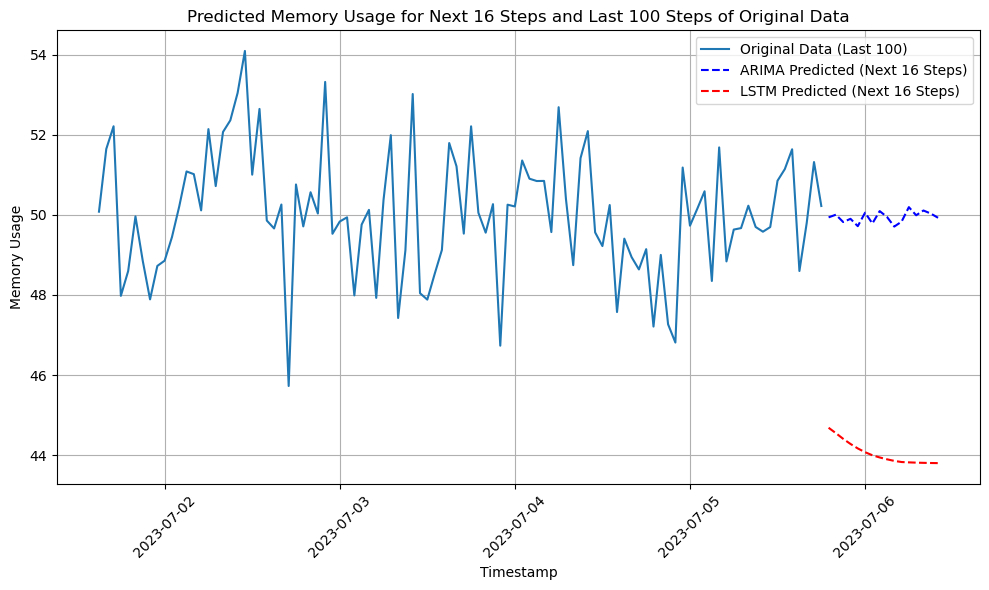

In [20]:
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(df.index[-100:], df['memory_usage'][-100:], label='Original Data (Last 100)')

# Plot ARIMA predicted data
plt.plot(pd.date_range(start=df.index[-1], periods=17, freq='H')[1:], forecast_next_16, label='ARIMA Predicted (Next 16 Steps)', color='blue', linestyle='--')

# Plot LSTM predicted data
plt.plot(pd.date_range(start=df.index[-1], periods=17, freq='H')[1:], predicted_values, label='LSTM Predicted (Next 16 Steps)', color='red', linestyle='--')

plt.xlabel('Timestamp')
plt.ylabel('Memory Usage')
plt.title('Predicted Memory Usage for Next 16 Steps and Last 100 Steps of Original Data')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


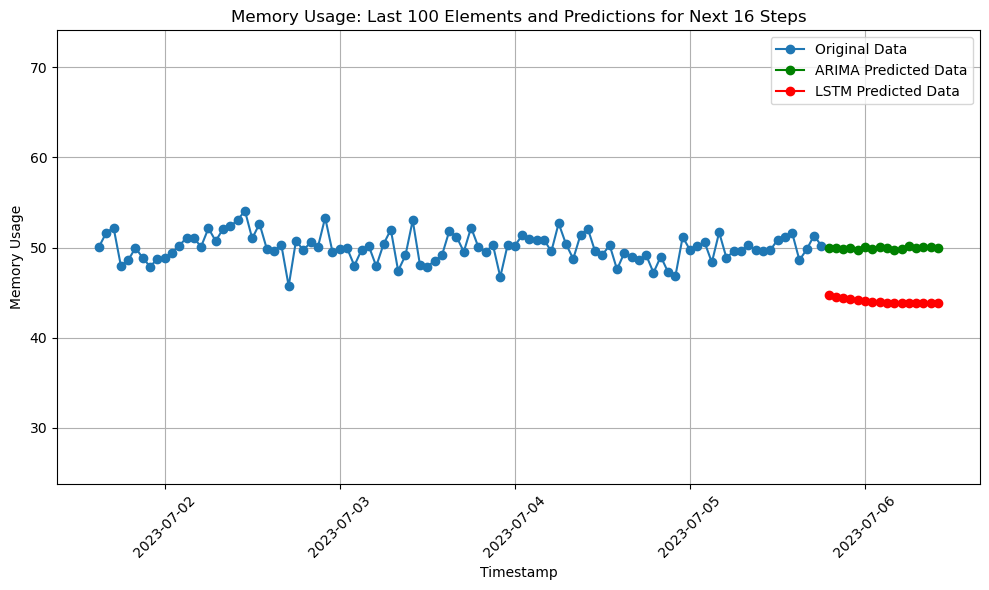

In [22]:
# Select the last 100 rows of the DataFrame
last_100_elements = df.tail(100)

# Plot the graph with decreased scale
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(last_100_elements.index, last_100_elements['memory_usage'], marker='o', linestyle='-', label='Original Data')

# Plot ARIMA predicted data
plt.plot(last_100_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), forecast_next_16, marker='o', linestyle='-', color='green', label='ARIMA Predicted Data')

# Plot LSTM predicted data
plt.plot(last_100_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), predicted_values, marker='o', linestyle='-', color='red', label='LSTM Predicted Data')

# Set y-axis limits with further decreased scale for better visibility
y_min = min(last_100_elements['memory_usage'].min(), np.min(predicted_values), np.min(forecast_next_16)) - 20
y_max = max(last_100_elements['memory_usage'].max(), np.max(predicted_values), np.max(forecast_next_16)) + 20
plt.ylim(y_min, y_max)

# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('Memory Usage')
plt.title('Memory Usage: Last 100 Elements and Predictions for Next 16 Steps')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show legend
plt.legend()

# Add grid
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Create and fit the Exponential Smoothing model
model3 = ExponentialSmoothing(df['memory_usage'], trend='add', seasonal='add', seasonal_periods=24)  # Adjust parameters as needed
result3 = model3.fit()

# Print model summary
print(result3.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:             memory_usage   No. Observations:                 4459
Model:             ExponentialSmoothing   SSE                          10979.964
Optimized:                         True   AIC                           4074.217
Trend:                         Additive   BIC                           4253.492
Seasonal:                      Additive   AICC                          4074.637
Seasonal Periods:                    24   Date:                 Sun, 05 May 2024
Box-Cox:                          False   Time:                         14:29:43
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               3.813e-08                alpha                 True
smoothing_trend          

In [25]:
# Forecast the next 16 steps
forecast_next_16_model3 = result3.forecast(steps=16)

# Print the forecasted values
print("Forecasted values for the next 16 steps:")
print(forecast_next_16_model3)


Forecasted values for the next 16 steps:
2023-07-05 19:00:00    50.038465
2023-07-05 20:00:00    50.072065
2023-07-05 21:00:00    49.739797
2023-07-05 22:00:00    49.968027
2023-07-05 23:00:00    49.894704
2023-07-06 00:00:00    50.039585
2023-07-06 01:00:00    50.260553
2023-07-06 02:00:00    50.057753
2023-07-06 03:00:00    49.980831
2023-07-06 04:00:00    49.936283
2023-07-06 05:00:00    49.897814
2023-07-06 06:00:00    50.035186
2023-07-06 07:00:00    50.035604
2023-07-06 08:00:00    50.241290
2023-07-06 09:00:00    50.008465
2023-07-06 10:00:00    49.995338
Freq: H, dtype: float64


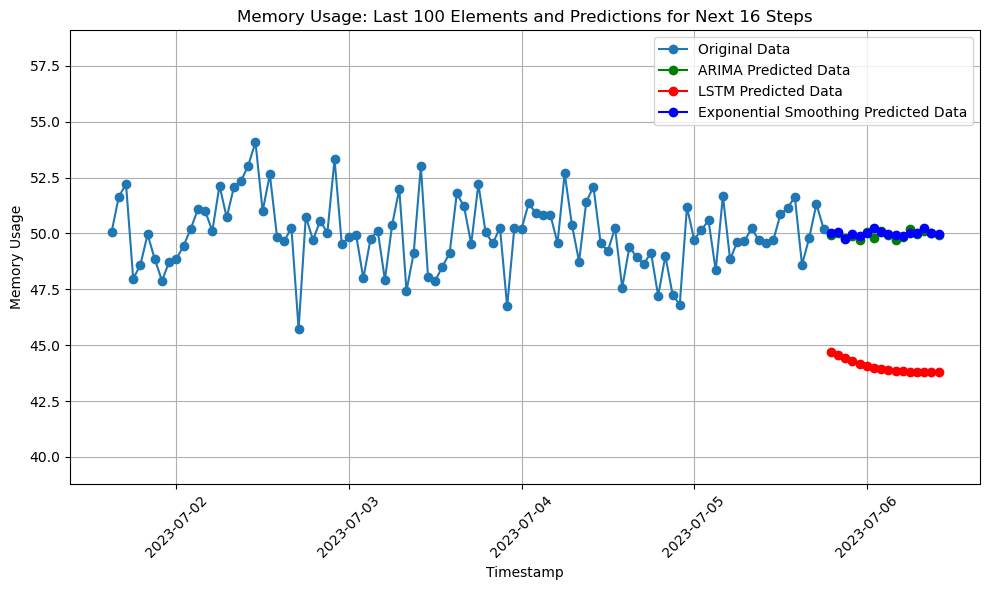

In [26]:
# Forecast next 16 steps using model3 (Exponential Smoothing)
forecast_next_16_model3 = result3.forecast(steps=16)

# Plot the graph with decreased scale
plt.figure(figsize=(10, 6))

# Plot original data
plt.plot(last_100_elements.index, last_100_elements['memory_usage'], marker='o', linestyle='-', label='Original Data')

# Plot ARIMA predicted data
plt.plot(last_100_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), forecast_next_16, marker='o', linestyle='-', color='green', label='ARIMA Predicted Data')

# Plot LSTM predicted data
plt.plot(last_100_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), predicted_values, marker='o', linestyle='-', color='red', label='LSTM Predicted Data')

# Plot Exponential Smoothing (model3) predicted data
plt.plot(last_100_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), forecast_next_16_model3, marker='o', linestyle='-', color='blue', label='Exponential Smoothing Predicted Data')

# Set y-axis limits with further decreased scale for better visibility
y_min = min(last_100_elements['memory_usage'].min(), np.min(predicted_values), np.min(forecast_next_16), np.min(forecast_next_16_model3)) - 5
y_max = max(last_100_elements['memory_usage'].max(), np.max(predicted_values), np.max(forecast_next_16), np.max(forecast_next_16_model3)) + 5
plt.ylim(y_min, y_max)

# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('Memory Usage')
plt.title('Memory Usage: Last 100 Elements and Predictions for Next 16 Steps')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show legend
plt.legend()

# Add grid
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


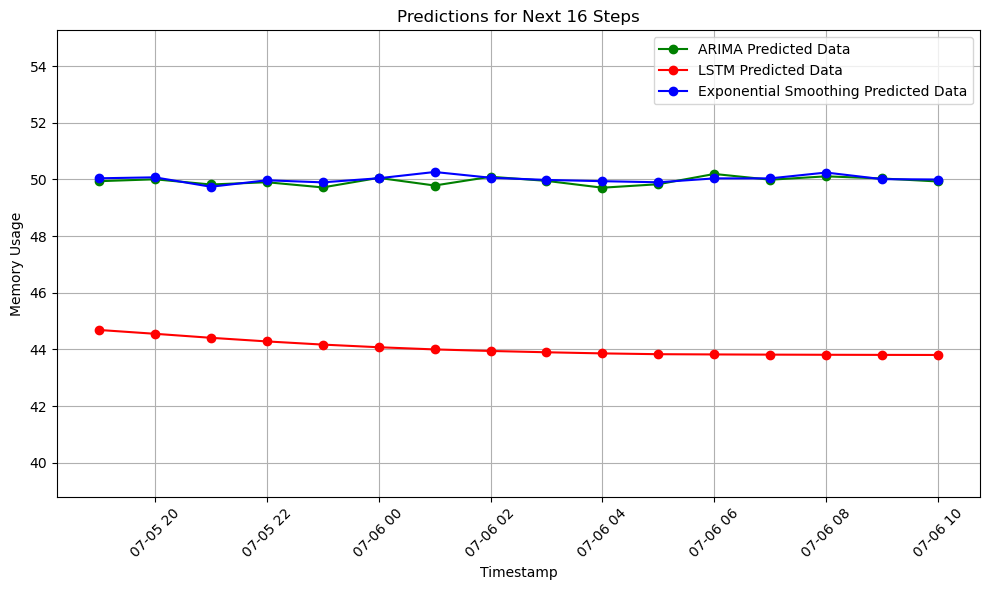

In [27]:
# Select the last 20 rows of the DataFrame
last_20_elements = df.tail(20)

# Plot the graph with increased scale for better visibility
plt.figure(figsize=(10, 6))

# Plot ARIMA predicted data
plt.plot(last_20_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), forecast_next_16, marker='o', linestyle='-', color='green', label='ARIMA Predicted Data')

# Plot LSTM predicted data
plt.plot(last_20_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), predicted_values, marker='o', linestyle='-', color='red', label='LSTM Predicted Data')

# Plot Exponential Smoothing (model3) predicted data
plt.plot(last_20_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), forecast_next_16_model3, marker='o', linestyle='-', color='blue', label='Exponential Smoothing Predicted Data')

# Set y-axis limits with further decreased scale for better visibility
y_min = min(np.min(predicted_values), np.min(forecast_next_16), np.min(forecast_next_16_model3)) - 5
y_max = max(np.max(predicted_values), np.max(forecast_next_16), np.max(forecast_next_16_model3)) + 5
plt.ylim(y_min, y_max)

# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('Memory Usage')
plt.title('Predictions for Next 16 Steps')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show legend
plt.legend()

# Add grid
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


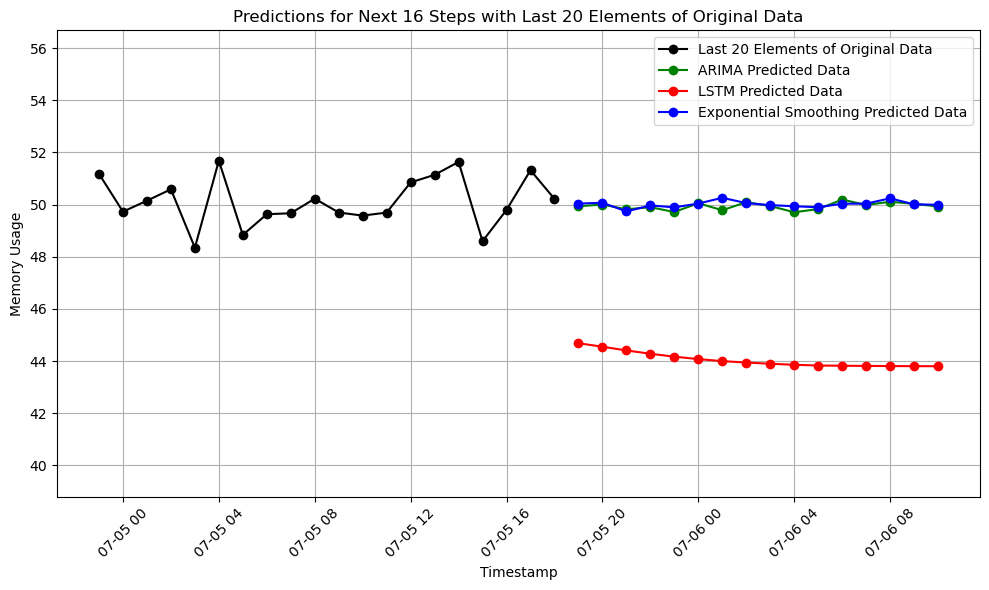

In [28]:
# Select the last 20 rows of the DataFrame
last_20_elements = df.tail(20)

# Plot the graph with increased scale for better visibility
plt.figure(figsize=(10, 6))

# Plot last 20 elements of original data
plt.plot(last_20_elements.index, last_20_elements['memory_usage'], marker='o', linestyle='-', color='black', label='Last 20 Elements of Original Data')

# Plot ARIMA predicted data
plt.plot(last_20_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), forecast_next_16, marker='o', linestyle='-', color='green', label='ARIMA Predicted Data')

# Plot LSTM predicted data
plt.plot(last_20_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), predicted_values, marker='o', linestyle='-', color='red', label='LSTM Predicted Data')

# Plot Exponential Smoothing (model3) predicted data
plt.plot(last_20_elements.index[-1] + pd.to_timedelta(np.arange(1, 17), unit='H'), forecast_next_16_model3, marker='o', linestyle='-', color='blue', label='Exponential Smoothing Predicted Data')

# Set y-axis limits with further decreased scale for better visibility
y_min = min(np.min(predicted_values), np.min(forecast_next_16), np.min(forecast_next_16_model3), np.min(last_20_elements['memory_usage'])) - 5
y_max = max(np.max(predicted_values), np.max(forecast_next_16), np.max(forecast_next_16_model3), np.max(last_20_elements['memory_usage'])) + 5
plt.ylim(y_min, y_max)

# Set labels and title
plt.xlabel('Timestamp')
plt.ylabel('Memory Usage')
plt.title('Predictions for Next 16 Steps with Last 20 Elements of Original Data')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Show legend
plt.legend()

# Add grid
plt.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()
